In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import pandas as pd
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import string
from nltk.tokenize import word_tokenize
import joblib
import os

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Function to preprocess Hindi text and transliterated Hindi text
def preprocess_hindi_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase (for English and transliterated Hindi portions)
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove mentions and handle replaced patterns
    text = re.sub(r'@\w+|<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Hindi-specific cleaning:
    # 1. Keep Hindi unicode range intact (\u0900-\u097F)
    
    # 3. For English and transliterated portions, handle differently
    
    # Custom punctuation removal - careful to preserve Hindi specific characters
    # Remove only basic Latin punctuation while preserving Hindi script,  script and English characters
    custom_punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    translator = str.maketrans('', '', custom_punctuation)
    text = text.translate(translator)
    
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Handle multilingual code-switching by preserving all scripts
    # Tokenize, preserving Hindi,  and English terms
    tokens = word_tokenize(text)
    
    # Rejoin the tokens into processed text
    text = ' '.join(tokens)
    
    return text

# Function to calculate majority vote
def majority_vote(row):
    # Extract annotation columns - adjust these column names for your  dataset
    annotation_cols = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def read_csv_with_fallbacks(file_path):
    """
    Try different strategies to read a CSV file until one works.
    
    Args:
        file_path: Path to the CSV file
        
    Returns:
        pandas DataFrame if successful, None otherwise
    """
    strategies = [
        {"params": {"quoting": csv.QUOTE_MINIMAL}, "desc": "Default with QUOTE_MINIMAL"},
        {"params": {"quoting": csv.QUOTE_NONE, "engine": "python"}, "desc": "Python engine with QUOTE_NONE"},
        {"params": {"quoting": csv.QUOTE_NONE, "engine": "python", "on_bad_lines": "skip"}, "desc": "Python engine with bad lines skipping"},
        {"params": {"sep": ",", "encoding": "utf-8", "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "UTF-8 with comma separator"},
        {"params": {"sep": ",", "encoding": "latin1", "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Latin-1 encoding"},
        {"params": {"sep": ",", "encoding": "utf-8", "engine": "python", "quoting": csv.QUOTE_NONE, "on_bad_lines": "skip", "escapechar": "\\"}, "desc": "With escape characters"},
        {"params": {"sep": "\t", "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Tab separator"},
        {"params": {"sep": None, "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Auto-detect separator"},
        {"params": {"sep": ",", "lineterminator": "\n", "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Explicit lineterminator"},
        {"params": {"chunksize": 10000, "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Reading in chunks"}
    ]
    
    print(f"Attempting to read {file_path}...")
    
    # Try each strategy
    for i, strategy in enumerate(strategies):
        try:
            print(f"Attempt {i+1}: {strategy['desc']}")
            
            # For the chunking strategy, handle differently
            if "chunksize" in strategy["params"]:
                chunks = pd.read_csv(file_path, **strategy["params"])
                df = pd.concat(chunks, ignore_index=True)
            else:
                df = pd.read_csv(file_path, **strategy["params"])
            
            print(f"Success! Read {len(df)} rows with strategy: {strategy['desc']}")
            return df
            
        except Exception as e:
            print(f"Failed with error: {str(e)[:100]}...")
    
    # If we get here, try one last approach - manual reading
    try:
        print("Final attempt: Manual line-by-line reading...")
        
        # Read file line by line
        rows = []
        with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
            reader = csv.reader((line.replace('\0', '') for line in f))
            headers = next(reader)
            for row in reader:
                # Ensure row has correct number of fields
                if len(row) == len(headers):
                    rows.append(row)
                else:
                    # Pad short rows, trim long rows
                    if len(row) < len(headers):
                        row.extend([''] * (len(headers) - len(row)))
                    else:
                        row = row[:len(headers)]
                    rows.append(row)
        
        df = pd.DataFrame(rows, columns=headers)
        print(f"Manual reading successful! Read {len(df)} rows.")
        return df
        
    except Exception as e:
        print(f"All attempts failed. Last error: {str(e)}")
        return None

def train_hindi_classifier(train_file, test_file=None):
    """
    Train a Hindi text classifier using Logistic Regression and evaluate on test data.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file using our robust method
        train_df = read_csv_with_fallbacks(train_file)
        
        if train_df is None:
            print("Failed to read training data. Exiting.")
            return None, None, None
        
        # Preprocess text column
        print("Preprocessing training Hindi text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_hindi_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('training_class_distribution_hindi.png')
        print("Class distribution plot saved as 'training_class_distribution_hindi.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Create a pipeline with TF-IDF and Logistic Regression - optimized for Hindi
        print("\nCreating and training the model...")
        
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(
                max_features=10000,
                ngram_range=(1, 3),    # Unigrams, bigrams, and trigrams for Tamil
                min_df=1,              # Lower threshold for Tamil due to potential sparsity
                max_df=0.95,           # Ignore terms that appear in more than 95% of documents
                analyzer='char_wb',    # Character n-grams for Tamil works better
                sublinear_tf=True      # Apply sublinear tf scaling
            )),
            ('classifier', SVC(
                C=5.0,                 # Regularization parameter
                kernel='linear',       # Linear kernel for text classification
                class_weight='balanced', # Handle class imbalance
                probability=True,      # Enable probability estimates
                random_state=42
            ))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        print("Model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            # Read the test data using our robust method
            test_df = read_csv_with_fallbacks(test_file)
            
            if test_df is None:
                print("Failed to read test data. Skipping evaluation.")
                return pipeline, None, None
            
            # Preprocess test text
            print("Preprocessing test Hindi text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_hindi_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix for Hindi Text Classification')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('confusion_matrix_hindi.png')
            print("Confusion matrix saved as 'confusion_matrix_hindi.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('test_predictions_hindi.csv', index=False)
            print("Test predictions saved to 'test_predictions_hindi.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing T text...")
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def save_model(model, model_path='hindi_classifier_model.pkl'):
    """
    Save the trained model to a file
    
    Args:
        model: Trained classifier pipeline
        model_path: Path where to save the model
    """
    try:
        print(f"Saving hindi model to {model_path}...")
        joblib.dump(model, model_path)
        print(f"Model saved successfully to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model_and_predict(model_path='hindi_classifier_model.pkl', 
                           test_file=None, sample_text=None):
    """
    Load a trained model and use it for inference on a test file or sample text
    
    Args:
        model_path: Path to the saved model file
        test_file: Path to a CSV file containing texts to predict
        sample_text: A single text string to predict
        
    Returns:
        Predictions or a single prediction
    """
    try:
        # Load the model
        print(f"Loading hindi model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        
        if test_file and os.path.exists(test_file):
            # Predict on test file
            print(f"Predicting on test file: {test_file}")
            df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess text
            df['processed_text'] = df['text'].apply(preprocess_hindi_text)
            
            # Make predictions
            predictions_class = model.predict(df['processed_text'])
            predictions_value = [float(pred) for pred in predictions_class]
            
            # Add predictions to dataframe
            df['predicted_label_class'] = predictions_class
            df['predicted_label_value'] = predictions_value
            
            # Save results
            output_file = "predictions_hindi_output.csv"
            df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")
            
            return df
            
        elif sample_text:
            # Predict on a single text
            print("Predicting on sample hindi text...")
            processed_text = preprocess_hindi_text(sample_text)
            prediction_class = model.predict([processed_text])[0]
            prediction_value = float(prediction_class)
            
            print(f"Text: {sample_text}")
            print(f"Processed text: {processed_text}")
            print(f"Prediction (class): {prediction_class}")
            print(f"Prediction (value): {prediction_value}")
            
            return prediction_class, prediction_value
        
        else:
            print("Error: Please provide either a test file or sample text.")
            return None
            
    except Exception as e:
        print(f"Error during inference: {e}")
        import traceback
        traceback.print_exc()
        return None

Attempting to read /kaggle/input/capstone/uli_dataset-main/training/train_hi_l1.csv...
Attempt 1: Default with QUOTE_MINIMAL
Success! Read 6197 rows with strategy: Default with QUOTE_MINIMAL
Preprocessing training Hindi text...
Calculating majority vote for training labels...

Training class distribution:
label_class
0.0    4436
1.0    1760
0.5       1
Name: count, dtype: int64
Class distribution plot saved as 'training_class_distribution_hindi.png'

Creating and training the model...
Model training complete!
Attempting to read /kaggle/input/capstone/uli_dataset-main/testing/test_hi_l1.csv...
Attempt 1: Default with QUOTE_MINIMAL
Failed with error: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.
...
Attempt 2: Python engine with QUOTE_NONE
Failed with error: Expected 8 fields in line 6, saw 9...
Attempt 3: Python engine with bad lines skipping
Success! Read 1352 rows with strategy: Python engine with bad lines skipping
Preprocessing test Hindi te

Traceback (most recent call last):
  File "/tmp/ipykernel_31/1325548788.py", line 410, in load_model_and_predict
    df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/io/parsers/readers.py", line 626, in _read
    return parser.read(nrows)
           ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/io/parsers/readers.py", line 1923, in read
    ) = self._engine.read(  # type: ignore[attr-defined]
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/io/parsers/c_parser_wrapper.py", line 234, in read
    chunks = self._reader.read_low_memory(nrows)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

Text: tere se nahi hoga yu cant do it आप यह नहीं कर सकते 
Processed text: tere se nahi hoga yu cant do it आप यह नहीं कर सकते
Prediction (class): 0.0
Prediction (value): 0.0


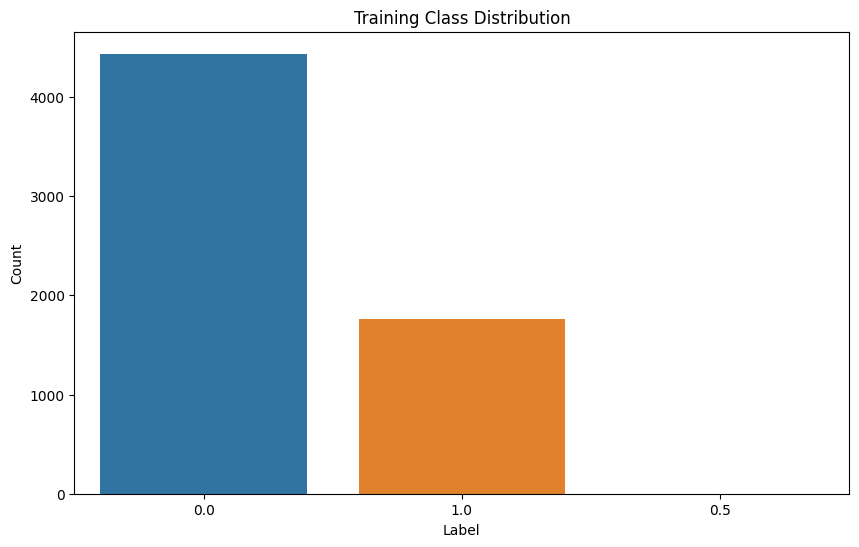

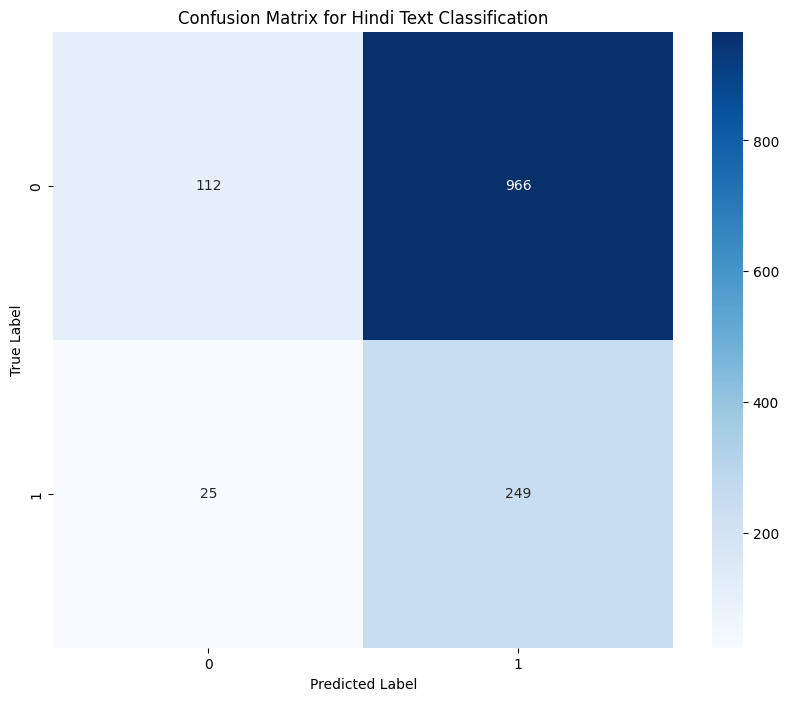

In [5]:
if __name__ == "__main__":
    train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_hi_l1.csv"
    test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_hi_l1.csv"
    
    # Train the model and evaluate on test data
    model, macro_f1, report = train_hindi_classifier(train_file, test_file)
    
    # Save the trained model
    if model is not None:
        model_path = "/kaggle/working/hindi_classifier_model_svm_l1.pkl"
        save_model(model, model_path)
        
        # Example of loading the model and making predictions
        print("\n=== Example: Using saved model for inference ===")
        
        # Example 1: Predict on test file
        test_predictions = load_model_and_predict(
            model_path=model_path,
            test_file=test_file
        )
        
        # Example 2: Predict on a sample text
        
        sample_text = "tere se nahi hoga yu cant do it आप यह नहीं कर सकते "
        single_prediction = load_model_and_predict(
            model_path=model_path,
            sample_text=sample_text
        )

In [6]:
import pandas as pd
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import string
from nltk.tokenize import word_tokenize
import joblib
import os

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Function to preprocess Hindi text and transliterated Hindi text
def preprocess_hindi_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase (for English and transliterated Hindi portions)
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove mentions and handle replaced patterns
    text = re.sub(r'@\w+|<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Hindi-specific cleaning:
    # 1. Keep Hindi unicode range intact (\u0900-\u097F)
    
    # 3. For English and transliterated portions, handle differently
    
    # Custom punctuation removal - careful to preserve Hindi specific characters
    # Remove only basic Latin punctuation while preserving Hindi script,  script and English characters
    custom_punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    translator = str.maketrans('', '', custom_punctuation)
    text = text.translate(translator)
    
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Handle multilingual code-switching by preserving all scripts
    # Tokenize, preserving Hindi,  and English terms
    tokens = word_tokenize(text)
    
    # Rejoin the tokens into processed text
    text = ' '.join(tokens)
    
    return text

# Function to calculate majority vote
def majority_vote(row):
    # Extract annotation columns - adjust these column names for your  dataset
    annotation_cols = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def read_csv_with_fallbacks(file_path):
    """
    Try different strategies to read a CSV file until one works.
    
    Args:
        file_path: Path to the CSV file
        
    Returns:
        pandas DataFrame if successful, None otherwise
    """
    strategies = [
        {"params": {"quoting": csv.QUOTE_MINIMAL}, "desc": "Default with QUOTE_MINIMAL"},
        {"params": {"quoting": csv.QUOTE_NONE, "engine": "python"}, "desc": "Python engine with QUOTE_NONE"},
        {"params": {"quoting": csv.QUOTE_NONE, "engine": "python", "on_bad_lines": "skip"}, "desc": "Python engine with bad lines skipping"},
        {"params": {"sep": ",", "encoding": "utf-8", "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "UTF-8 with comma separator"},
        {"params": {"sep": ",", "encoding": "latin1", "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Latin-1 encoding"},
        {"params": {"sep": ",", "encoding": "utf-8", "engine": "python", "quoting": csv.QUOTE_NONE, "on_bad_lines": "skip", "escapechar": "\\"}, "desc": "With escape characters"},
        {"params": {"sep": "\t", "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Tab separator"},
        {"params": {"sep": None, "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Auto-detect separator"},
        {"params": {"sep": ",", "lineterminator": "\n", "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Explicit lineterminator"},
        {"params": {"chunksize": 10000, "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Reading in chunks"}
    ]
    
    print(f"Attempting to read {file_path}...")
    
    # Try each strategy
    for i, strategy in enumerate(strategies):
        try:
            print(f"Attempt {i+1}: {strategy['desc']}")
            
            # For the chunking strategy, handle differently
            if "chunksize" in strategy["params"]:
                chunks = pd.read_csv(file_path, **strategy["params"])
                df = pd.concat(chunks, ignore_index=True)
            else:
                df = pd.read_csv(file_path, **strategy["params"])
            
            print(f"Success! Read {len(df)} rows with strategy: {strategy['desc']}")
            return df
            
        except Exception as e:
            print(f"Failed with error: {str(e)[:100]}...")
    
    # If we get here, try one last approach - manual reading
    try:
        print("Final attempt: Manual line-by-line reading...")
        
        # Read file line by line
        rows = []
        with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
            reader = csv.reader((line.replace('\0', '') for line in f))
            headers = next(reader)
            for row in reader:
                # Ensure row has correct number of fields
                if len(row) == len(headers):
                    rows.append(row)
                else:
                    # Pad short rows, trim long rows
                    if len(row) < len(headers):
                        row.extend([''] * (len(headers) - len(row)))
                    else:
                        row = row[:len(headers)]
                    rows.append(row)
        
        df = pd.DataFrame(rows, columns=headers)
        print(f"Manual reading successful! Read {len(df)} rows.")
        return df
        
    except Exception as e:
        print(f"All attempts failed. Last error: {str(e)}")
        return None

def train_hindi_classifier(train_file, test_file=None):
    """
    Train a Hindi text classifier using Logistic Regression and evaluate on test data.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file using our robust method
        train_df = read_csv_with_fallbacks(train_file)
        
        if train_df is None:
            print("Failed to read training data. Exiting.")
            return None, None, None
        
        # Preprocess text column
        print("Preprocessing training Hindi text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_hindi_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('training_class_distribution_hindi.png')
        print("Class distribution plot saved as 'training_class_distribution_hindi.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Create a pipeline with TF-IDF and Logistic Regression - optimized for Hindi
        print("\nCreating and training the model...")
        
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(
                max_features=10000,
                ngram_range=(1, 3),    # Unigrams, bigrams, and trigrams for Tamil
                min_df=1,              # Lower threshold for Tamil due to potential sparsity
                max_df=0.95,           # Ignore terms that appear in more than 95% of documents
                analyzer='char_wb',    # Character n-grams for Tamil works better
                sublinear_tf=True      # Apply sublinear tf scaling
            )),
            ('classifier', SVC(
                C=5.0,                 # Regularization parameter
                kernel='linear',       # Linear kernel for text classification
                class_weight='balanced', # Handle class imbalance
                probability=True,      # Enable probability estimates
                random_state=42
            ))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        print("Model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            # Read the test data using our robust method
            test_df = read_csv_with_fallbacks(test_file)
            
            if test_df is None:
                print("Failed to read test data. Skipping evaluation.")
                return pipeline, None, None
            
            # Preprocess test text
            print("Preprocessing test Hindi text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_hindi_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix for Hindi Text Classification')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('confusion_matrix_hindi.png')
            print("Confusion matrix saved as 'confusion_matrix_hindi.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('test_predictions_hindi.csv', index=False)
            print("Test predictions saved to 'test_predictions_hindi.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing T text...")
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def save_model(model, model_path='hindi_classifier_model.pkl'):
    """
    Save the trained model to a file
    
    Args:
        model: Trained classifier pipeline
        model_path: Path where to save the model
    """
    try:
        print(f"Saving hindi model to {model_path}...")
        joblib.dump(model, model_path)
        print(f"Model saved successfully to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model_and_predict(model_path='hindi_classifier_model.pkl', 
                           test_file=None, sample_text=None):
    """
    Load a trained model and use it for inference on a test file or sample text
    
    Args:
        model_path: Path to the saved model file
        test_file: Path to a CSV file containing texts to predict
        sample_text: A single text string to predict
        
    Returns:
        Predictions or a single prediction
    """
    try:
        # Load the model
        print(f"Loading hindi model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        
        if test_file and os.path.exists(test_file):
            # Predict on test file
            print(f"Predicting on test file: {test_file}")
            df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess text
            df['processed_text'] = df['text'].apply(preprocess_hindi_text)
            
            # Make predictions
            predictions_class = model.predict(df['processed_text'])
            predictions_value = [float(pred) for pred in predictions_class]
            
            # Add predictions to dataframe
            df['predicted_label_class'] = predictions_class
            df['predicted_label_value'] = predictions_value
            
            # Save results
            output_file = "predictions_hindi_output.csv"
            df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")
            
            return df
            
        elif sample_text:
            # Predict on a single text
            print("Predicting on sample hindi text...")
            processed_text = preprocess_hindi_text(sample_text)
            prediction_class = model.predict([processed_text])[0]
            prediction_value = float(prediction_class)
            
            print(f"Text: {sample_text}")
            print(f"Processed text: {processed_text}")
            print(f"Prediction (class): {prediction_class}")
            print(f"Prediction (value): {prediction_value}")
            
            return prediction_class, prediction_value
        
        else:
            print("Error: Please provide either a test file or sample text.")
            return None
            
    except Exception as e:
        print(f"Error during inference: {e}")
        import traceback
        traceback.print_exc()
        return None

Attempting to read /kaggle/input/capstone/uli_dataset-main/training/train_hi_l2.csv...
Attempt 1: Default with QUOTE_MINIMAL
Success! Read 6191 rows with strategy: Default with QUOTE_MINIMAL
Preprocessing training Hindi text...
Calculating majority vote for training labels...

Training class distribution:
label_class
0.0    3147
1.0    3044
Name: count, dtype: int64
Class distribution plot saved as 'training_class_distribution_hindi.png'

Creating and training the model...
Model training complete!
Attempting to read /kaggle/input/capstone/uli_dataset-main/testing/test_hi_l2.csv...
Attempt 1: Default with QUOTE_MINIMAL
Failed with error: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.
...
Attempt 2: Python engine with QUOTE_NONE
Failed with error: Expected 8 fields in line 6, saw 9...
Attempt 3: Python engine with bad lines skipping
Success! Read 1352 rows with strategy: Python engine with bad lines skipping
Preprocessing test Hindi text...
Calcul

Traceback (most recent call last):
  File "/tmp/ipykernel_31/1325548788.py", line 410, in load_model_and_predict
    df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/io/parsers/readers.py", line 626, in _read
    return parser.read(nrows)
           ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/io/parsers/readers.py", line 1923, in read
    ) = self._engine.read(  # type: ignore[attr-defined]
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/io/parsers/c_parser_wrapper.py", line 234, in read
    chunks = self._reader.read_low_memory(nrows)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

Model loaded successfully!
Predicting on sample hindi text...
Text: tere se nahi hoga yu cant do it आप यह नहीं कर सकते 
Processed text: tere se nahi hoga yu cant do it आप यह नहीं कर सकते
Prediction (class): 1.0
Prediction (value): 1.0


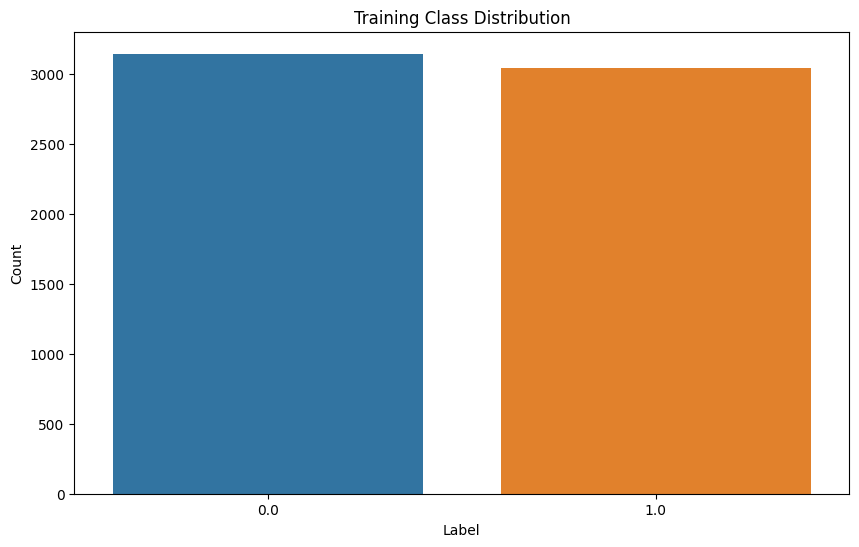

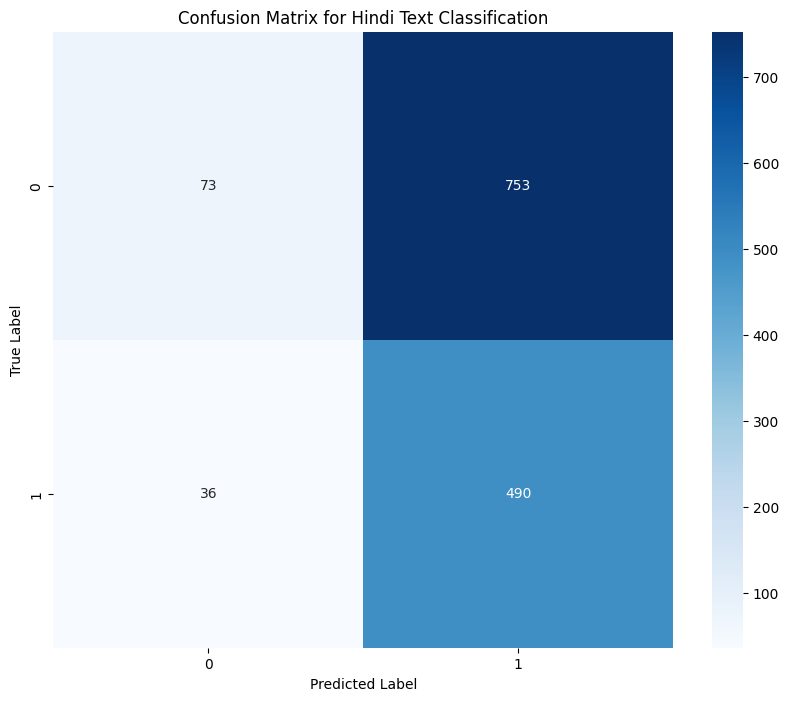

In [7]:
if __name__ == "__main__":
    train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_hi_l2.csv"
    test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_hi_l2.csv"
    
    # Train the model and evaluate on test data
    model, macro_f1, report = train_hindi_classifier(train_file, test_file)
    
    # Save the trained model
    if model is not None:
        model_path = "/kaggle/working/hindi_classifier_model_svm_l2.pkl"
        save_model(model, model_path)
        
        # Example of loading the model and making predictions
        print("\n=== Example: Using saved model for inference ===")
        
        # Example 1: Predict on test file
        test_predictions = load_model_and_predict(
            model_path=model_path,
            test_file=test_file
        )
        
        # Example 2: Predict on a sample text
        
        sample_text = "tere se nahi hoga yu cant do it आप यह नहीं कर सकते "
        single_prediction = load_model_and_predict(
            model_path=model_path,
            sample_text=sample_text
        )

In [8]:
import pandas as pd
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import string
from nltk.tokenize import word_tokenize
import joblib
import os

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Function to preprocess Hindi text and transliterated Hindi text
def preprocess_hindi_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase (for English and transliterated Hindi portions)
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove mentions and handle replaced patterns
    text = re.sub(r'@\w+|<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Hindi-specific cleaning:
    # 1. Keep Hindi unicode range intact (\u0900-\u097F)
    
    # 3. For English and transliterated portions, handle differently
    
    # Custom punctuation removal - careful to preserve Hindi specific characters
    # Remove only basic Latin punctuation while preserving Hindi script,  script and English characters
    custom_punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    translator = str.maketrans('', '', custom_punctuation)
    text = text.translate(translator)
    
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Handle multilingual code-switching by preserving all scripts
    # Tokenize, preserving Hindi,  and English terms
    tokens = word_tokenize(text)
    
    # Rejoin the tokens into processed text
    text = ' '.join(tokens)
    
    return text

# Function to calculate majority vote
def majority_vote(row):
    # Extract annotation columns - adjust these column names for your  dataset
    annotation_cols = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def read_csv_with_fallbacks(file_path):
    """
    Try different strategies to read a CSV file until one works.
    
    Args:
        file_path: Path to the CSV file
        
    Returns:
        pandas DataFrame if successful, None otherwise
    """
    strategies = [
        {"params": {"quoting": csv.QUOTE_MINIMAL}, "desc": "Default with QUOTE_MINIMAL"},
        {"params": {"quoting": csv.QUOTE_NONE, "engine": "python"}, "desc": "Python engine with QUOTE_NONE"},
        {"params": {"quoting": csv.QUOTE_NONE, "engine": "python", "on_bad_lines": "skip"}, "desc": "Python engine with bad lines skipping"},
        {"params": {"sep": ",", "encoding": "utf-8", "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "UTF-8 with comma separator"},
        {"params": {"sep": ",", "encoding": "latin1", "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Latin-1 encoding"},
        {"params": {"sep": ",", "encoding": "utf-8", "engine": "python", "quoting": csv.QUOTE_NONE, "on_bad_lines": "skip", "escapechar": "\\"}, "desc": "With escape characters"},
        {"params": {"sep": "\t", "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Tab separator"},
        {"params": {"sep": None, "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Auto-detect separator"},
        {"params": {"sep": ",", "lineterminator": "\n", "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Explicit lineterminator"},
        {"params": {"chunksize": 10000, "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Reading in chunks"}
    ]
    
    print(f"Attempting to read {file_path}...")
    
    # Try each strategy
    for i, strategy in enumerate(strategies):
        try:
            print(f"Attempt {i+1}: {strategy['desc']}")
            
            # For the chunking strategy, handle differently
            if "chunksize" in strategy["params"]:
                chunks = pd.read_csv(file_path, **strategy["params"])
                df = pd.concat(chunks, ignore_index=True)
            else:
                df = pd.read_csv(file_path, **strategy["params"])
            
            print(f"Success! Read {len(df)} rows with strategy: {strategy['desc']}")
            return df
            
        except Exception as e:
            print(f"Failed with error: {str(e)[:100]}...")
    
    # If we get here, try one last approach - manual reading
    try:
        print("Final attempt: Manual line-by-line reading...")
        
        # Read file line by line
        rows = []
        with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
            reader = csv.reader((line.replace('\0', '') for line in f))
            headers = next(reader)
            for row in reader:
                # Ensure row has correct number of fields
                if len(row) == len(headers):
                    rows.append(row)
                else:
                    # Pad short rows, trim long rows
                    if len(row) < len(headers):
                        row.extend([''] * (len(headers) - len(row)))
                    else:
                        row = row[:len(headers)]
                    rows.append(row)
        
        df = pd.DataFrame(rows, columns=headers)
        print(f"Manual reading successful! Read {len(df)} rows.")
        return df
        
    except Exception as e:
        print(f"All attempts failed. Last error: {str(e)}")
        return None

def train_hindi_classifier(train_file, test_file=None):
    """
    Train a Hindi text classifier using Logistic Regression and evaluate on test data.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file using our robust method
        train_df = read_csv_with_fallbacks(train_file)
        
        if train_df is None:
            print("Failed to read training data. Exiting.")
            return None, None, None
        
        # Preprocess text column
        print("Preprocessing training Hindi text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_hindi_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('training_class_distribution_hindi.png')
        print("Class distribution plot saved as 'training_class_distribution_hindi.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Create a pipeline with TF-IDF and Logistic Regression - optimized for Hindi
        print("\nCreating and training the model...")
        
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(
                max_features=10000,
                ngram_range=(1, 3),    # Unigrams, bigrams, and trigrams for Tamil
                min_df=1,              # Lower threshold for Tamil due to potential sparsity
                max_df=0.95,           # Ignore terms that appear in more than 95% of documents
                analyzer='char_wb',    # Character n-grams for Tamil works better
                sublinear_tf=True      # Apply sublinear tf scaling
            )),
            ('classifier', SVC(
                C=5.0,                 # Regularization parameter
                kernel='linear',       # Linear kernel for text classification
                class_weight='balanced', # Handle class imbalance
                probability=True,      # Enable probability estimates
                random_state=42
            ))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        print("Model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            # Read the test data using our robust method
            test_df = read_csv_with_fallbacks(test_file)
            
            if test_df is None:
                print("Failed to read test data. Skipping evaluation.")
                return pipeline, None, None
            
            # Preprocess test text
            print("Preprocessing test Hindi text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_hindi_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix for Hindi Text Classification')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('confusion_matrix_hindi.png')
            print("Confusion matrix saved as 'confusion_matrix_hindi.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('test_predictions_hindi.csv', index=False)
            print("Test predictions saved to 'test_predictions_hindi.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing T text...")
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def save_model(model, model_path='hindi_classifier_model.pkl'):
    """
    Save the trained model to a file
    
    Args:
        model: Trained classifier pipeline
        model_path: Path where to save the model
    """
    try:
        print(f"Saving hindi model to {model_path}...")
        joblib.dump(model, model_path)
        print(f"Model saved successfully to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model_and_predict(model_path='hindi_classifier_model.pkl', 
                           test_file=None, sample_text=None):
    """
    Load a trained model and use it for inference on a test file or sample text
    
    Args:
        model_path: Path to the saved model file
        test_file: Path to a CSV file containing texts to predict
        sample_text: A single text string to predict
        
    Returns:
        Predictions or a single prediction
    """
    try:
        # Load the model
        print(f"Loading hindi model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        
        if test_file and os.path.exists(test_file):
            # Predict on test file
            print(f"Predicting on test file: {test_file}")
            df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess text
            df['processed_text'] = df['text'].apply(preprocess_hindi_text)
            
            # Make predictions
            predictions_class = model.predict(df['processed_text'])
            predictions_value = [float(pred) for pred in predictions_class]
            
            # Add predictions to dataframe
            df['predicted_label_class'] = predictions_class
            df['predicted_label_value'] = predictions_value
            
            # Save results
            output_file = "predictions_hindi_output.csv"
            df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")
            
            return df
            
        elif sample_text:
            # Predict on a single text
            print("Predicting on sample hindi text...")
            processed_text = preprocess_hindi_text(sample_text)
            prediction_class = model.predict([processed_text])[0]
            prediction_value = float(prediction_class)
            
            print(f"Text: {sample_text}")
            print(f"Processed text: {processed_text}")
            print(f"Prediction (class): {prediction_class}")
            print(f"Prediction (value): {prediction_value}")
            
            return prediction_class, prediction_value
        
        else:
            print("Error: Please provide either a test file or sample text.")
            return None
            
    except Exception as e:
        print(f"Error during inference: {e}")
        import traceback
        traceback.print_exc()
        return None

Attempting to read /kaggle/input/capstone/uli_dataset-main/training/train_hi_l3.csv...
Attempt 1: Default with QUOTE_MINIMAL
Success! Read 6197 rows with strategy: Default with QUOTE_MINIMAL
Preprocessing training Hindi text...
Calculating majority vote for training labels...

Training class distribution:
label_class
0.0    3331
1.0    2866
Name: count, dtype: int64
Class distribution plot saved as 'training_class_distribution_hindi.png'

Creating and training the model...
Model training complete!
Attempting to read /kaggle/input/capstone/uli_dataset-main/testing/test_hi_l3.csv...
Attempt 1: Default with QUOTE_MINIMAL
Failed with error: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.
...
Attempt 2: Python engine with QUOTE_NONE
Failed with error: Expected 8 fields in line 6, saw 9...
Attempt 3: Python engine with bad lines skipping
Success! Read 1352 rows with strategy: Python engine with bad lines skipping
Preprocessing test Hindi text...
Calcul

Traceback (most recent call last):
  File "/tmp/ipykernel_31/1325548788.py", line 410, in load_model_and_predict
    df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/io/parsers/readers.py", line 626, in _read
    return parser.read(nrows)
           ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/io/parsers/readers.py", line 1923, in read
    ) = self._engine.read(  # type: ignore[attr-defined]
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/io/parsers/c_parser_wrapper.py", line 234, in read
    chunks = self._reader.read_low_memory(nrows)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

Text: tere se nahi hoga yu cant do it आप यह नहीं कर सकते 
Processed text: tere se nahi hoga yu cant do it आप यह नहीं कर सकते
Prediction (class): 0.0
Prediction (value): 0.0


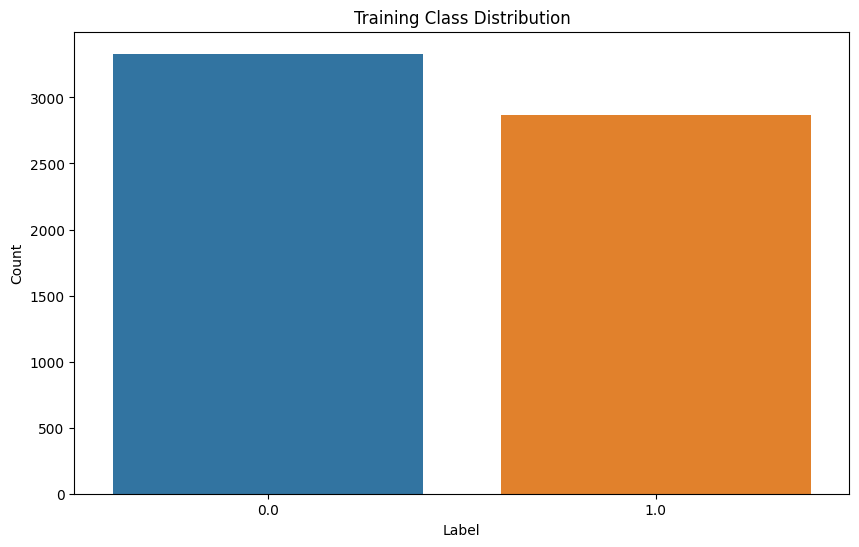

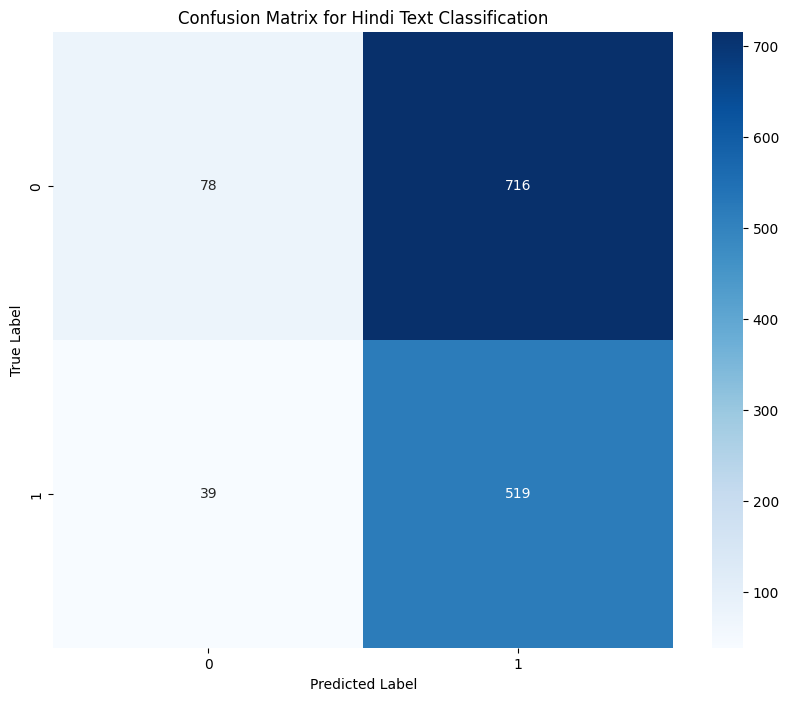

In [9]:
if __name__ == "__main__":
    train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_hi_l3.csv"
    test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_hi_l3.csv"
    
    # Train the model and evaluate on test data
    model, macro_f1, report = train_hindi_classifier(train_file, test_file)
    
    # Save the trained model
    if model is not None:
        model_path = "/kaggle/working/hindi_classifier_model_svm_l3.pkl"
        save_model(model, model_path)
        
        # Example of loading the model and making predictions
        print("\n=== Example: Using saved model for inference ===")
        
        # Example 1: Predict on test file
        test_predictions = load_model_and_predict(
            model_path=model_path,
            test_file=test_file
        )
        
        # Example 2: Predict on a sample text
        
        sample_text = "tere se nahi hoga yu cant do it आप यह नहीं कर सकते "
        single_prediction = load_model_and_predict(
            model_path=model_path,
            sample_text=sample_text
        )

In [14]:
import pandas as pd
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import string
from nltk.tokenize import word_tokenize
import joblib
import os
from sklearn.model_selection import train_test_split


# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')






def preprocess_hindi_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase (for English and transliterated Hindi portions)
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove mentions and handle replaced patterns
    text = re.sub(r'@\w+|<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Hindi-specific cleaning:
    # 1. Keep Hindi unicode range intact (\u0900-\u097F)
    
    # 3. For English and transliterated portions, handle differently
    
    # Custom punctuation removal - careful to preserve Hindi specific characters
    # Remove only basic Latin punctuation while preserving Hindi script,  script and English characters
    custom_punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    translator = str.maketrans('', '', custom_punctuation)
    text = text.translate(translator)
    
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Handle multilingual code-switching by preserving all scripts
    # Tokenize, preserving Hindi,  and English terms
    tokens = word_tokenize(text)
    
    # Rejoin the tokens into processed text
    text = ' '.join(tokens)
    
    return text


# Function to calculate majority vote for L1 dataset
def majority_vote_l1(row):
    # Extract annotation columns for L1
    annotation_cols = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

# Function to calculate majority vote for L3 dataset
def majority_vote_l3(row):
    # Extract annotation columns for L3
    annotation_cols = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5', 'hi_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def read_csv_with_fallbacks(file_path):
    """
    Try different strategies to read a CSV file until one works.
    
    Args:
        file_path: Path to the CSV file
        
    Returns:
        pandas DataFrame if successful, None otherwise
    """
    strategies = [
        {"params": {"quoting": csv.QUOTE_MINIMAL}, "desc": "Default with QUOTE_MINIMAL"},
        {"params": {"quoting": csv.QUOTE_NONE, "engine": "python"}, "desc": "Python engine with QUOTE_NONE"},
        {"params": {"quoting": csv.QUOTE_NONE, "engine": "python", "on_bad_lines": "skip"}, "desc": "Python engine with bad lines skipping"},
        {"params": {"sep": ",", "encoding": "utf-8", "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "UTF-8 with comma separator"},
        {"params": {"sep": ",", "encoding": "latin1", "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Latin-1 encoding"},
        {"params": {"sep": ",", "encoding": "utf-8", "engine": "python", "quoting": csv.QUOTE_NONE, "on_bad_lines": "skip", "escapechar": "\\"}, "desc": "With escape characters"},
        {"params": {"sep": "\t", "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Tab separator"},
        {"params": {"sep": None, "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Auto-detect separator"},
        {"params": {"sep": ",", "lineterminator": "\n", "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Explicit lineterminator"},
        {"params": {"chunksize": 10000, "engine": "python", "quoting": csv.QUOTE_NONE}, "desc": "Reading in chunks"}
    ]
    
    print(f"Attempting to read {file_path}...")
    
    # Try each strategy
    for i, strategy in enumerate(strategies):
        try:
            print(f"Attempt {i+1}: {strategy['desc']}")
            
            # For the chunking strategy, handle differently
            if "chunksize" in strategy["params"]:
                chunks = pd.read_csv(file_path, **strategy["params"])
                df = pd.concat(chunks, ignore_index=True)
            else:
                df = pd.read_csv(file_path, **strategy["params"])
            
            print(f"Success! Read {len(df)} rows with strategy: {strategy['desc']}")
            return df
            
        except Exception as e:
            print(f"Failed with error: {str(e)[:100]}...")
    
    # If we get here, try one last approach - manual reading
    try:
        print("Final attempt: Manual line-by-line reading...")
        
        # Read file line by line
        rows = []
        with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
            reader = csv.reader((line.replace('\0', '') for line in f))
            headers = next(reader)
            for row in reader:
                # Ensure row has correct number of fields
                if len(row) == len(headers):
                    rows.append(row)
                else:
                    # Pad short rows, trim long rows
                    if len(row) < len(headers):
                        row.extend([''] * (len(headers) - len(row)))
                    else:
                        row = row[:len(headers)]
                    rows.append(row)
        
        df = pd.DataFrame(rows, columns=headers)
        print(f"Manual reading successful! Read {len(df)} rows.")
        return df
        
    except Exception as e:
        print(f"All attempts failed. Last error: {str(e)}")
        return None


def train_combined_classifier_logistic_regression(l1_file, l3_file):
    """
    Combine L1 and L3 datasets, train a logistic regression model, and evaluate.
    Final label is 1 if both L1 and L3 are 1, otherwise 0.
    
    Args:
        l1_file: Path to the L1 CSV file
        l3_file: Path to the L3 CSV file
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the L1 CSV file
        print(f"Reading L1 data from {l1_file}...")
        l1_df = train_df = read_csv_with_fallbacks(l1_file)
        
        # Read the L3 CSV file
        print(f"Reading L3 data from {l3_file}...")
        l3_df = train_df = read_csv_with_fallbacks(l3_file)
        
        # Ensure both datasets have a unique ID to match sentences
        if 'id' not in l1_df.columns:
            l1_df['id'] = range(len(l1_df))
        if 'id' not in l3_df.columns:
            l3_df['id'] = range(len(l3_df))
        
        # Calculate majority vote for L1 dataset
        print("Calculating majority vote for L1 labels...")
        l1_df['l1_label'] = l1_df.apply(majority_vote_l1, axis=1)
        
        # Calculate majority vote for L3 dataset
        print("Calculating majority vote for L3 labels...")
        l3_df['l3_label'] = l3_df.apply(majority_vote_l3, axis=1)
        
        # Extract essential columns from each dataset
        l1_subset = l1_df[['id', 'text', 'l1_label']]
        l3_subset = l3_df[['id', 'l3_label']]
        
        # Merge datasets on ID
        print("Merging L1 and L3 datasets...")
        merged_df = pd.merge(l1_subset, l3_subset, on='id', how='inner')
        
        # Determine final label: 1 if both L1 and L3 are 1, otherwise 0
        merged_df['final_label'] = ((merged_df['l1_label'] == 1.0) & 
                                    (merged_df['l3_label'] == 1.0)).astype(int)
        
        # Preprocess text column
        print("Preprocessing text...")
        merged_df['processed_text'] = merged_df['text'].apply(preprocess_hindi_text)
        
        # Print the class distribution
        print("\nFinal label class distribution:")
        class_dist = merged_df['final_label'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='final_label', data=merged_df)
        plt.title('Combined Dataset Class Distribution')
        plt.xlabel('Final Label (1 if both L1 and L3 are 1, otherwise 0)')
        plt.ylabel('Count')
        plt.savefig('combined_class_distribution_lr.png')
        print("Class distribution plot saved as 'combined_class_distribution_lr.png'")
        
        # Split into training and testing sets (80% train, 20% test)
        X = merged_df['processed_text']
        y = merged_df['final_label']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print(f"Training data size: {len(X_train)}, Test data size: {len(X_test)}")
        
        # Create a pipeline with TF-IDF and Logistic Regression
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(
                max_features=10000,
                ngram_range=(1, 3),    # Unigrams, bigrams, and trigrams for Tamil
                min_df=1,              # Lower threshold for Tamil due to potential sparsity
                max_df=0.95,           # Ignore terms that appear in more than 95% of documents
                analyzer='char_wb',    # Character n-grams for Tamil works better
                sublinear_tf=True      # Apply sublinear tf scaling
            )),
            ('classifier', SVC(
                C=5.0,                 # Regularization parameter
                kernel='linear',       # Linear kernel for text classification
                class_weight='balanced', # Handle class imbalance
                probability=True,      # Enable probability estimates
                random_state=42
            ))
        ])
        # Train the model
        pipeline.fit(X_train, y_train)
        print("Model training complete!")
        
        # Get the most important features (coefficients)
        #feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
        #coefficients = pipeline.named_steps['classifier'].coef_[0]
        
        # Sort features by absolute coefficient value
        #sorted_coef_idx = np.argsort(np.abs(coefficients))
        #top_positive_features = [(feature_names[idx], coefficients[idx]) 
                                #for idx in sorted_coef_idx[-10:] if coefficients[idx] > 0]
        #top_negative_features = [(feature_names[idx], coefficients[idx]) 
                                #for idx in sorted_coef_idx[-10:] if coefficients[idx] < 0]
        
        #print("\nTop positive features (associated with label 1):")
        #for feature, coef in sorted(top_positive_features, key=lambda x: -x[1]):
            #print(f"  {feature}: {coef:.4f}")
            
        #print("\nTop negative features (associated with label 0):")
        #for feature, coef in sorted(top_negative_features, key=lambda x: x[1]):
            #print(f"  {feature}: {coef:.4f}")
        
        # Make predictions on test data
        print("\nMaking predictions on test data...")
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        print("\nEvaluating model performance...")
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        
        print(f"\nMacro F1 Score: {macro_f1:.4f}")
        print("\nDetailed Classification Report:")
        report = classification_report(y_test, y_pred)
        print(report)
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (Logistic Regression)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig('confusion_matrix_lr.png')
        print("Confusion matrix saved as 'confusion_matrix_lr.png'")
        
        # Save test predictions
        print("\nSaving test predictions...")
        results_df = pd.DataFrame({
            'text': X_test.values,
            'true_label': y_test.values,
            'predicted_label': y_pred,
            'probability_class_1': pipeline.predict_proba(X_test)[:, 1]
        })
        results_df.to_csv('test_predictions_lr.csv', index=False)
        print("Test predictions saved to 'test_predictions_lr.csv'")
        
        # Save the combined dataset with all labels
        merged_df.to_csv('combined_dataset_with_labels.csv', index=False)
        print("Combined dataset saved to 'combined_dataset_with_labels.csv'")
        
        return pipeline, macro_f1, report
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# Function to predict on new data
def predict_on_new_data_logistic_regression(model, input_file, output_file):
    """
    Use a trained logistic regression model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = train_df = read_csv_with_fallbacks(input_file)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions...")
        predictions = model.predict(df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(df['processed_text'])
        
        # Add predictions to dataframe
        df['predicted_label'] = predictions
        df['probability_class_1'] = prediction_probs[:, 1]
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions).value_counts()
        print(pred_dist)
        
        # Plot probability distribution
        plt.figure(figsize=(10, 6))
        plt.hist(df['probability_class_1'], bins=20)
        plt.title('Prediction Probability Distribution (Class 1)')
        plt.xlabel('Probability')
        plt.ylabel('Count')
        plt.savefig('prediction_probability_lr.png')
        print("Prediction probability plot saved as 'prediction_probability_lr.png'")
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def evaluate_on_combined_test_data(model, l1_test_file, l3_test_file, output_file='combined_test_predictions.csv'):
    """
    Combine L1 and L3 test datasets, evaluate the model, and save predictions.
    Final label is 1 if both L1 and L3 are 1, otherwise 0.
    
    Args:
        model: Trained classifier pipeline
        l1_test_file: Path to the L1 test CSV file
        l3_test_file: Path to the L3 test CSV file
        output_file: Path to save predictions
    
    Returns:
        Evaluation metrics and combined test dataframe
    """
    try:
        # Read the L1 test CSV file
        print(f"Reading L1 test data from {l1_test_file}...")
        l1_test_df = train_df = read_csv_with_fallbacks(l1_test_file)
        
        # Read the L3 test CSV file
        print(f"Reading L3 test data from {l3_test_file}...")
        l3_test_df = train_df = read_csv_with_fallbacks(l3_test_file)
        
        # Ensure both datasets have a unique ID to match sentences
        if 'id' not in l1_test_df.columns:
            l1_test_df['id'] = range(len(l1_test_df))
        if 'id' not in l3_test_df.columns:
            l3_test_df['id'] = range(len(l3_test_df))
        
        # Calculate majority vote for L1 test dataset
        print("Calculating majority vote for L1 test labels...")
        l1_test_df['l1_label'] = l1_test_df.apply(majority_vote_l1, axis=1)
        
        # Calculate majority vote for L3 test dataset
        print("Calculating majority vote for L3 test labels...")
        l3_test_df['l3_label'] = l3_test_df.apply(majority_vote_l3, axis=1)
        
        # Extract essential columns from each test dataset
        l1_test_subset = l1_test_df[['id', 'text', 'l1_label']]
        l3_test_subset = l3_test_df[['id', 'l3_label']]
        
        # Merge test datasets on ID
        print("Merging L1 and L3 test datasets...")
        merged_test_df = pd.merge(l1_test_subset, l3_test_subset, on='id', how='inner')
        
        # Determine final test label: 1 if both L1 and L3 are 1, otherwise 0
        merged_test_df['final_label'] = ((merged_test_df['l1_label'] == 1.0) & 
                                       (merged_test_df['l3_label'] == 1.0)).astype(int)
        
        # Preprocess text column
        print("Preprocessing test text...")
        merged_test_df['processed_text'] = merged_test_df['text'].apply(preprocess_hindi_text)
        
        # Print the test class distribution
        print("\nFinal test label class distribution:")
        test_class_dist = merged_test_df['final_label'].value_counts()
        print(test_class_dist)
        
        # Plot test class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='final_label', data=merged_test_df)
        plt.title('Combined Test Dataset Class Distribution')
        plt.xlabel('Final Label (1 if both L1 and L3 are 1, otherwise 0)')
        plt.ylabel('Count')
        plt.savefig('combined_test_class_distribution.png')
        print("Test class distribution plot saved as 'combined_test_class_distribution.png'")
        
        # Get test data
        X_test = merged_test_df['processed_text']
        y_test = merged_test_df['final_label']
        
        print(f"Test data size: {len(X_test)}")
        
        # Make predictions on test data
        print("\nMaking predictions on combined test data...")
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        print("\nEvaluating model performance on test data...")
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        
        print(f"\nMacro F1 Score on test data: {macro_f1:.4f}")
        print("\nDetailed Classification Report on test data:")
        test_report = classification_report(y_test, y_pred)
        print(test_report)
        
        # Create confusion matrix for test data
        test_cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Test Data Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig('test_confusion_matrix.png')
        print("Test confusion matrix saved as 'test_confusion_matrix.png'")
        
        # Save test predictions
        print("\nSaving combined test predictions...")
        results_df = pd.DataFrame({
            'id': merged_test_df['id'],
            'text': X_test.values,
            'l1_label': merged_test_df['l1_label'],
            'l3_label': merged_test_df['l3_label'],
            'true_combined_label': y_test.values,
            'predicted_label': y_pred,
            'probability_class_1': model.predict_proba(X_test)[:, 1]
        })
        results_df.to_csv(output_file, index=False)
        print(f"Combined test predictions saved to '{output_file}'")
        
        # Plot probability distribution for test data
        plt.figure(figsize=(10, 6))
        plt.hist(results_df['probability_class_1'], bins=20)
        plt.title('Test Prediction Probability Distribution (Class 1)')
        plt.xlabel('Probability')
        plt.ylabel('Count')
        plt.savefig('test_prediction_probability.png')
        print("Test prediction probability plot saved as 'test_prediction_probability.png'")
        
        return macro_f1, test_report, results_df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# Add these imports at the top of your file with the other imports
import joblib
import os

# Add this function to save the trained model
def save_model(model, model_path='trained_combined_classifier.joblib'):
    """
    Save the trained model to disk.
    
    Args:
        model: Trained classifier pipeline
        model_path: Path to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(model_path) if os.path.dirname(model_path) else '.', exist_ok=True)
        # Save the model
        joblib.dump(model, model_path)
        print(f"Model successfully saved to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        import traceback
        traceback.print_exc()
        return False

# Add this function to load a saved model and perform inference
def load_model_and_predict(model_path, text_samples):
    """
    Load a trained model and make predictions on sample text.
    
    Args:
        model_path: Path to the saved model
        text_samples: List of text strings to predict on
        
    Returns:
        DataFrame with predictions
    """
    try:
        # Load the model
        print(f"Loading model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        
        # Create a dataframe from the text samples
        samples_df = pd.DataFrame({'text': text_samples})
        
        # Preprocess the text
        print("Preprocessing sample text...")
        samples_df['processed_text'] = samples_df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions on samples...")
        predictions = model.predict(samples_df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(samples_df['processed_text'])
        
        # Add predictions to dataframe
        samples_df['predicted_label'] = predictions
        samples_df['probability_class_1'] = prediction_probs[:, 1]
        
        # Display results
        print("\nPrediction Results:")
        for i, (text, pred, prob) in enumerate(zip(
            text_samples, predictions, prediction_probs[:, 1])):
            label = "Potential issue detected" if pred == 1 else "No issue detected"
            print(f"\nSample {i+1}:")
            print(f"Text: {text[:100]}..." if len(text) > 100 else f"Text: {text}")
            print(f"Prediction: {label} (Class {pred})")
            print(f"Confidence: {prob:.4f}")
        
        return samples_df
        
    except Exception as e:
        print(f"Error during model loading or prediction: {e}")
        import traceback
        traceback.print_exc()
        return None

# Add this usage example function
def demo_inference(model_path='trained_combined_classifier.joblib'):
    """
    Demonstrate model inference with sample texts.
    
    Args:
        model_path: Path to the saved model
    """
    # Sample texts to test the model
    sample_texts = [
        "This restaurant would not serve me because of my race.",
        "I really enjoyed the movie, it was entertaining from start to finish.",
        "They refused to hire me because I'm too old for the position.",
        "The weather today is quite pleasant, perfect for a walk in the park.",
        "This company consistently pays women less than men for the same work."
    ]
    
    # Run inference
    results = load_model_and_predict(model_path, sample_texts)
    
    # Save results to CSV if available
    if results is not None:
        results.to_csv('sample_predictions.csv', index=False)
        print("\nSample predictions saved to 'sample_predictions.csv'")

Reading L1 data from /kaggle/input/capstone/uli_dataset-main/training/train_hi_l1.csv...
Attempting to read /kaggle/input/capstone/uli_dataset-main/training/train_hi_l1.csv...
Attempt 1: Default with QUOTE_MINIMAL
Success! Read 6197 rows with strategy: Default with QUOTE_MINIMAL
Reading L3 data from /kaggle/input/capstone/uli_dataset-main/training/train_hi_l3.csv...
Attempting to read /kaggle/input/capstone/uli_dataset-main/training/train_hi_l3.csv...
Attempt 1: Default with QUOTE_MINIMAL
Success! Read 6197 rows with strategy: Default with QUOTE_MINIMAL
Calculating majority vote for L1 labels...
Calculating majority vote for L3 labels...
Merging L1 and L3 datasets...
Preprocessing text...

Final label class distribution:
final_label
0    4875
1    1322
Name: count, dtype: int64
Class distribution plot saved as 'combined_class_distribution_lr.png'
Training data size: 4957, Test data size: 1240
Model training complete!

Making predictions on test data...

Evaluating model performance...


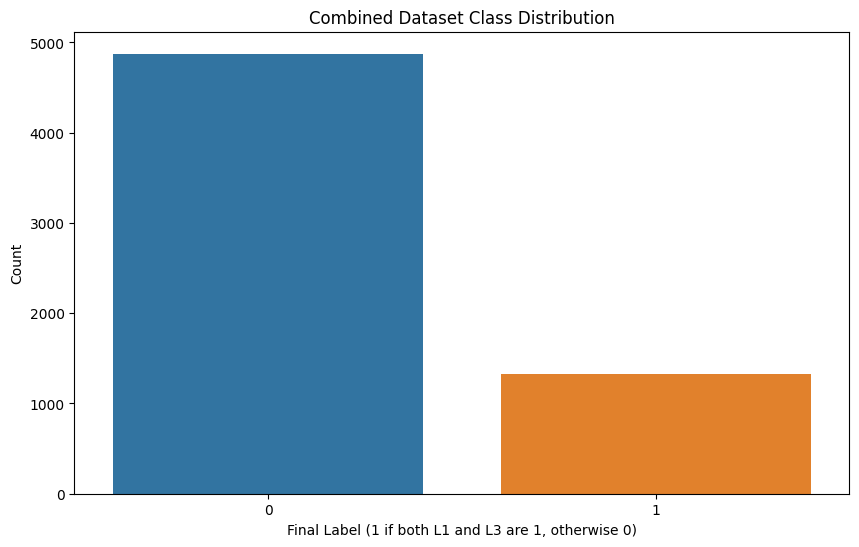

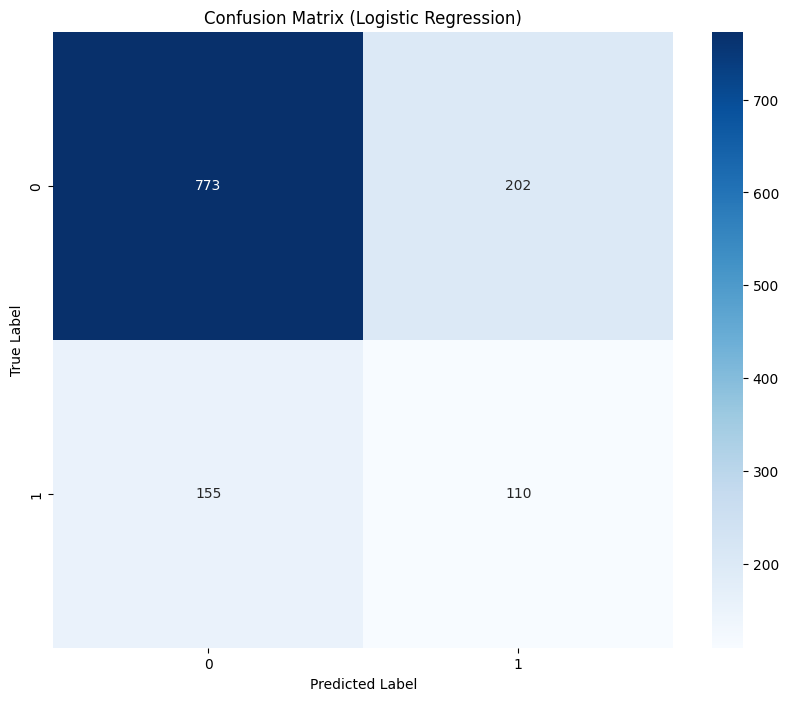

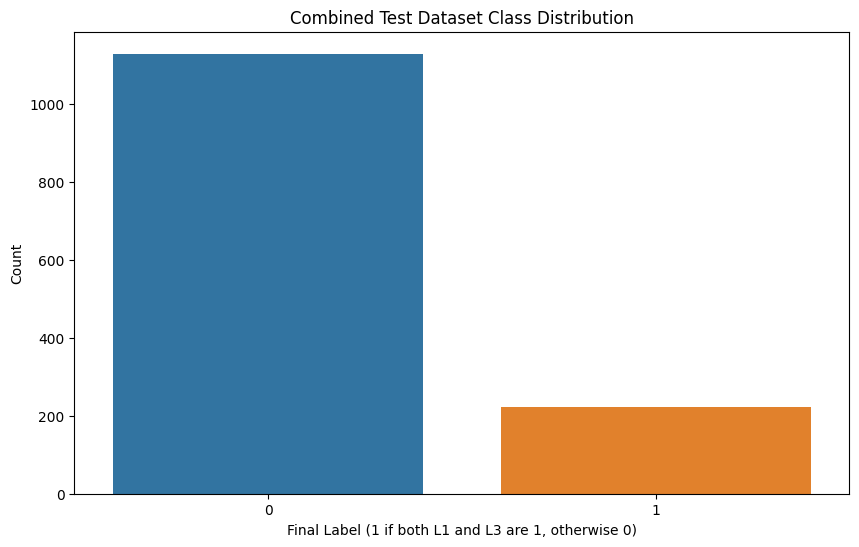

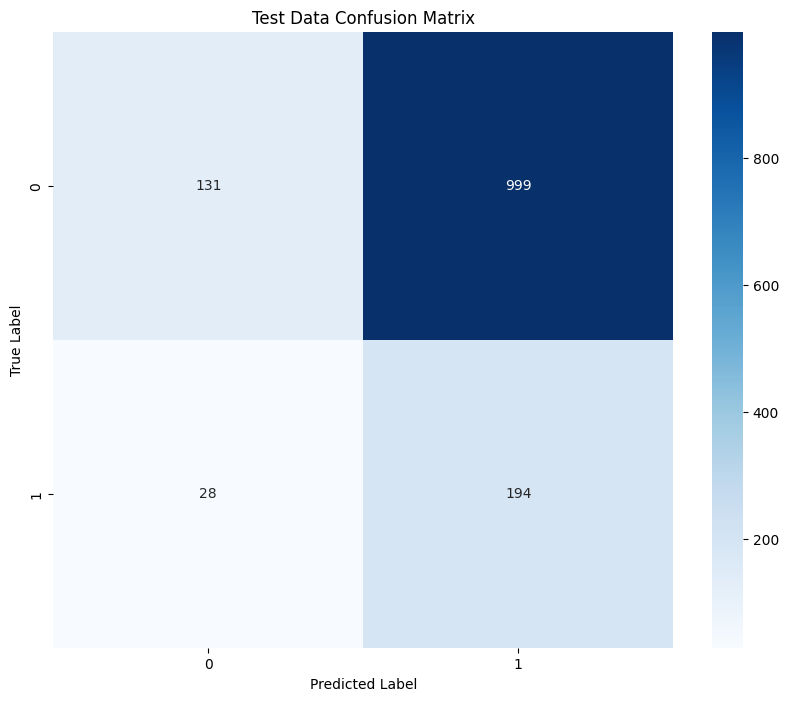

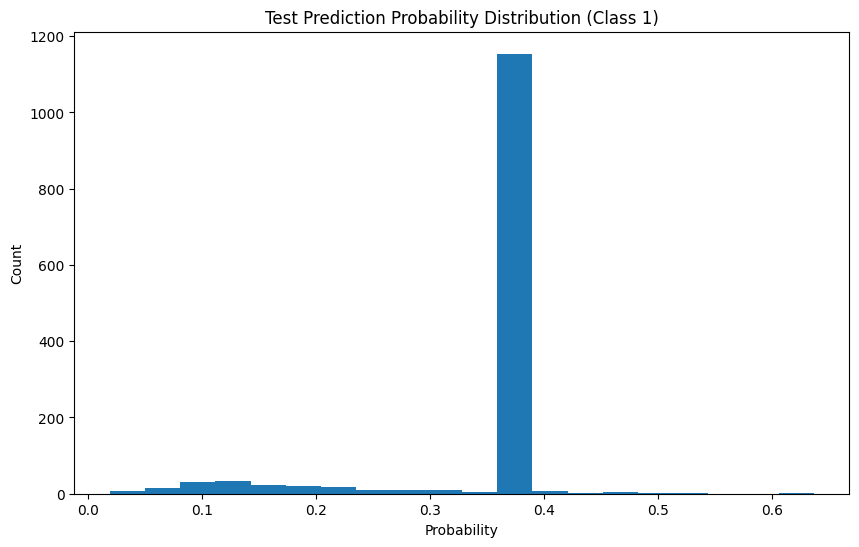

In [15]:
if __name__ == "__main__":
    # File paths for train data
    l1_train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_hi_l1.csv"
    l3_train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_hi_l3.csv"
    
    # File paths for test data
    l1_test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_hi_l1.csv"
    l3_test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_hi_l3.csv"
    
    # Train the model on combined training data
    model, train_macro_f1, train_report = train_combined_classifier_logistic_regression(l1_train_file, l3_train_file)
    
    # If model was successfully trained, save it and evaluate on combined test data
    if model is not None:
        # Save the trained model
        model_path = "trained_combined_classifier_ta.joblib"
        save_model(model, model_path)
        
        print("\n=== Evaluating model on combined test data ===")
        test_macro_f1, test_report, test_predictions = evaluate_on_combined_test_data(
            model, l1_test_file, l3_test_file
        )
        
        # Compare training and test performance
        if test_macro_f1 is not None and train_macro_f1 is not None:
            print("\n=== Performance Comparison ===")
            print(f"Training Macro F1: {train_macro_f1:.4f}")
            print(f"Test Macro F1: {test_macro_f1:.4f}")
            print(f"Difference: {abs(train_macro_f1 - test_macro_f1):.4f}")
            
            # Check for overfitting
            if train_macro_f1 > test_macro_f1 + 0.05:
                print("Note: The model may be overfitting as training performance is significantly better than test performance.")
            else:
                print("The model generalizes well to unseen data.")
        
        # Demo the inference function with sample texts
        print("\n=== Running inference demo with sample texts ===")
        demo_inference(model_path)